In [1]:
# wrangling
import numpy as np
import pandas as pd

# geospatial data
import fiona
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, MiniMap, Search
from shapely.geometry import Point
import matplotlib.pyplot as plt


%matplotlib inline
# others
from datetime import datetime

# original
from shapely.geometry import Point
import feather
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, log_loss
from copy import deepcopy
from datetime import datetime


//anaconda/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [2]:

def exchange_coordinate(df, lon, lat, prefix):
    """
    return df with fixed coordinate
    """
    lon_fix_name = prefix + "_lon_fix"
    lat_fix_name = prefix + "_lat_fix"

    df[lon_fix_name] = df[lon]
    df[lat_fix_name] = df[lat]

    df.loc[df[lat] < 0, lon_fix_name] = df.loc[df[lat] < 0, lat]
    df.loc[df[lat] < 0, lat_fix_name] = df.loc[df[lat] < 0, lon]

    return df

def epsg_converter(geodf):
    """
    return geodataframe with crs
    """
    crs = {'init': 'epsg:4326'}
    geodf = geodf.to_crs(crs)

    return geodf


def df_2_geodf(df, crs, lon, lat):
    """
    return geodataframe
    """
    geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
    geodf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

    return geodf

In [3]:
# Import Results
probs_df = pd.read_csv("./results/y_probs.csv", index_col=0, parse_dates=True)
print(probs_df.shape)
probs_df = probs_df.stack().reset_index()
probs_df.columns = ["datetime", "geoid10", "probabiltiy"]
probs_df.head()

(15495, 195)


,datetime,geoid10,probabiltiy
0,2015-09-17 08:00:00,06075010100,0.387637
1,2015-09-17 08:00:00,06075010200,0.241744
2,2015-09-17 08:00:00,06075010300,0.098925
3,2015-09-17 08:00:00,06075010400,0.095542
4,2015-09-17 08:00:00,06075010500,0.292688


In [4]:
tracts_df = gpd.read_file('./data/census2010_ sf_tracks.geojson')
tracts_df = tracts_df.loc[tracts_df.tractce10 != "980401",
                          ['geometry', "geoid10"]]
tracts_geodf = epsg_converter(tracts_df)
tracts_geodf.head()

,geometry,geoid10
0,"(POLYGON ((-122.446471 37.775802, -122.44478 3...",06075016500
1,"(POLYGON ((-122.44034 37.77658, -122.439844 37...",06075016400
2,"(POLYGON ((-122.429152 37.778007, -122.428909 ...",06075016300
3,"(POLYGON ((-122.428909 37.778039, -122.429152 ...",06075016100
4,"(POLYGON ((-122.420425 37.780583, -122.420336 ...",06075016000


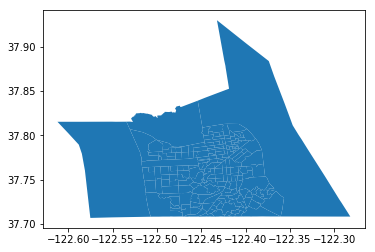

In [5]:
tracts_geodf.plot()

In [6]:
# merge
probs_df = pd.merge(probs_df, tracts_geodf, on="geoid10")
probs_geodf = gpd.GeoDataFrame(probs_df)
probs_geodf.crs = tracts_geodf.crs
probs_geodf.head()

,datetime,geoid10,probabiltiy,geometry
0,2015-09-17 08:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
1,2015-09-17 10:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
2,2015-09-17 12:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
3,2015-09-17 14:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
4,2015-09-17 16:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."


In [7]:
probs_2019_geodf = probs_geodf[probs_geodf["datetime"] > datetime(2019,3,31)]
probs_2019_geodf["datetime"] = probs_2019_geodf["datetime"].astype(str)
probs_2019_geodf['tract'] = probs_2019_geodf.geoid10.str[5:].astype(int)
probs_2019_geodf.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,datetime,geoid10,probabiltiy,geometry,tract
15485,2019-03-31 02:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100
15486,2019-03-31 04:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100
15487,2019-03-31 06:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100
15488,2019-03-31 08:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100
15489,2019-03-31 10:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100


In [8]:
# Import census data
census = pd.read_csv('./data/nhgis0002_csv/nhgis0002_ds233_20175_2017_tract.csv', encoding="latin_1")
print(census.columns)
census.head()

Index([u'GISJOIN', u'YEAR', u'REGIONA', u'DIVISIONA', u'STATE', u'STATEA',
       u'COUNTY', u'COUNTYA', u'COUSUBA', u'PLACEA', u'TRACTA', u'BLKGRPA',
       u'CONCITA', u'AIANHHA', u'RES_ONLYA', u'TRUSTA', u'AITSCEA', u'ANRCA',
       u'CBSAA', u'CSAA', u'METDIVA', u'NECTAA', u'CNECTAA', u'NECTADIVA',
       u'UAA', u'CDCURRA', u'SLDUA', u'SLDLA', u'ZCTA5A', u'SUBMCDA',
       u'SDELMA', u'SDSECA', u'SDUNIA', u'PUMA5A', u'BTTRA', u'BTBGA',
       u'NAME_E', u'AHYOE001', u'AHY2E001', u'AHY2E002', u'AHY2E003',
       u'AHY2E004', u'AHY2E005', u'AHY2E006', u'AHY2E007', u'AHY2E008',
       u'AHY2E009', u'AHY2E010', u'NAME_M', u'AHYOM001', u'AHY2M001',
       u'AHY2M002', u'AHY2M003', u'AHY2M004', u'AHY2M005', u'AHY2M006',
       u'AHY2M007', u'AHY2M008', u'AHY2M009', u'AHY2M010'],
      dtype='object')


,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,AHY2M001,AHY2M002,AHY2M003,AHY2M004,AHY2M005,AHY2M006,AHY2M007,AHY2M008,AHY2M009,AHY2M010
0,G0100010020100,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,199,187,57,11,21,11,11,65,11,65
1,G0100010020200,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,271,146,196,11,36,20,12,38,11,38
2,G0100010020300,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,400,387,316,29,33,19,325,78,11,78
3,G0100010020400,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,466,351,189,33,16,11,376,80,31,73
4,G0100010020500,2013-2017,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,...,802,646,618,16,144,16,16,186,16,186


In [9]:
# Clean census data
# AHY2E001:    Total
# AHY2E002:    White alone
# AHY2E003:    Black or African American alone
# AHY2E004:    American Indian and Alaska Native alone
# AHY2E005:    Asian alone
# AHY2E006:    Native Hawaiian and Other Pacific Islander alone
# AHY2E007:    Some other race alone

census.columns  = [x.lower() for x in census.columns]
census = census[(census['state'] == "California") & (census['county'] == "San Francisco County")]
census = census[['tracta','ahy2e001','ahy2e002','ahy2e003',
                 'ahy2e004','ahy2e005','ahy2e006','ahy2e007']]
census = census.rename(index=str, columns={"tracta": "tract", 
                                           "ahy2e001": "pop_all",
                                           "ahy2e002": "pop_white",
                                           "ahy2e003": "pop_black",
                                           "ahy2e004": "pop_native",
                                           "ahy2e005": "pop_asian",
                                           "ahy2e006": "pop_pacific",
                                           "ahy2e007": "pop_other"})

census['pct_white'] = census.pop_white / census.pop_all
census['pct_black'] = census.pop_black / census.pop_all
census['pct_native'] = census.pop_native / census.pop_all
census['pct_asian'] = census.pop_asian / census.pop_all
census['pct_pacific'] = census.pop_pacific / census.pop_all
census['pct_other'] = census.pop_other / census.pop_all
census.head()


,tract,pop_all,pop_white,pop_black,pop_native,pop_asian,pop_pacific,pop_other,pct_white,pct_black,pct_native,pct_asian,pct_pacific,pct_other
9846,10100,3967,1955,135,0,1549,0,189,0.492816,0.034031,0.000000,0.390471,0.000000,0.047643
9847,10200,4363,3677,34,0,488,9,57,0.842769,0.007793,0.000000,0.111850,0.002063,0.013064
9848,10300,4377,2708,0,0,1445,0,120,0.618689,0.000000,0.000000,0.330135,0.000000,0.027416
9849,10400,4645,2772,1,4,1320,0,71,0.596771,0.000215,0.000861,0.284177,0.000000,0.015285
9850,10500,2691,1487,243,0,659,0,47,0.552583,0.090301,0.000000,0.244890,0.000000,0.017466


In [10]:
census.describe()

,tract,pop_all,pop_white,pop_black,pop_native,pop_asian,pop_pacific,pop_other,pct_white,pct_black,pct_native,pct_asian,pct_pacific,pct_other
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,59066.269036,4387.121827,2072.416244,231.746193,16.781726,1499.223350,16.375635,328.934010,0.487391,0.057980,0.004016,0.322405,0.004607,0.073740
std,177993.075103,1850.167870,1157.982098,339.684918,35.889116,1212.361838,43.779608,396.313498,0.216645,0.085289,0.009227,0.189093,0.016235,0.081471
min,10100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042980,0.000000,0.000000,0.050036,0.000000,0.000000
25%,15900.000000,3413.000000,1235.000000,59.000000,0.000000,533.000000,0.000000,56.000000,0.337211,0.014407,0.000000,0.150489,0.000000,0.015032
50%,23001.000000,4281.000000,2014.000000,120.000000,1.000000,1105.000000,0.000000,163.000000,0.493264,0.028335,0.000750,0.296305,0.000000,0.039143
75%,31302.000000,5120.000000,2864.000000,274.000000,20.000000,2161.000000,14.000000,456.000000,0.665982,0.069728,0.004676,0.469634,0.003299,0.106839
max,990100.000000,13864.000000,7341.000000,2802.000000,399.000000,5307.000000,324.000000,1939.000000,0.886574,0.617589,0.090027,0.913823,0.150895,0.359607


In [11]:
# Merge with prediction
census_prob = pd.merge(probs_2019_geodf, census, on="tract")
census_prob.head()

,datetime,geoid10,probabiltiy,geometry,tract,pop_all,pop_white,pop_black,pop_native,pop_asian,pop_pacific,pop_other,pct_white,pct_black,pct_native,pct_asian,pct_pacific,pct_other
0,2019-03-31 02:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100,3967,1955,135,0,1549,0,189,0.492816,0.034031,0.0,0.390471,0.0,0.047643
1,2019-03-31 04:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100,3967,1955,135,0,1549,0,189,0.492816,0.034031,0.0,0.390471,0.0,0.047643
2,2019-03-31 06:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100,3967,1955,135,0,1549,0,189,0.492816,0.034031,0.0,0.390471,0.0,0.047643
3,2019-03-31 08:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100,3967,1955,135,0,1549,0,189,0.492816,0.034031,0.0,0.390471,0.0,0.047643
4,2019-03-31 10:00:00,06075010100,0.342068,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",10100,3967,1955,135,0,1549,0,189,0.492816,0.034031,0.0,0.390471,0.0,0.047643


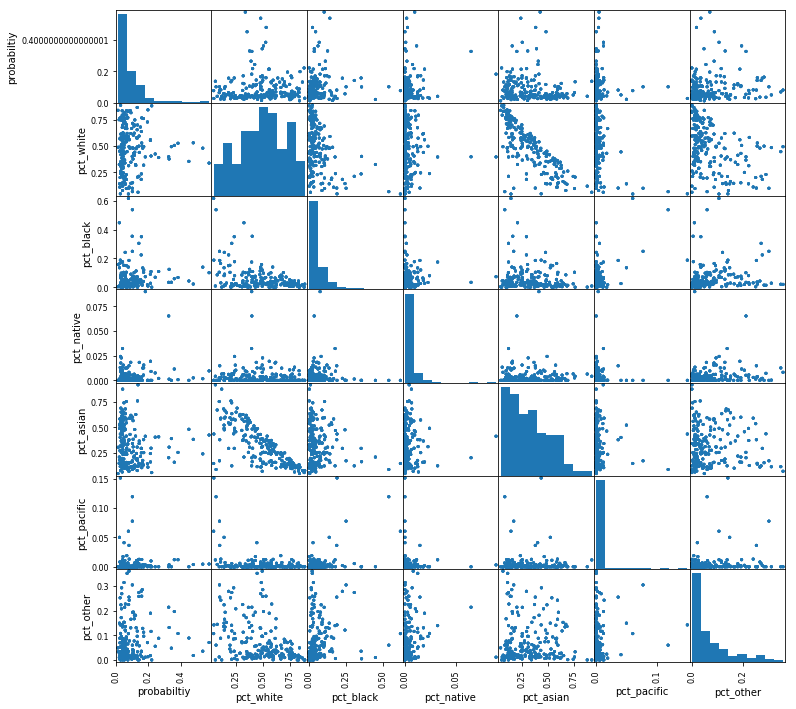

In [12]:
census_prob_corr = census_prob[['probabiltiy', 'pct_white', 'pct_black','pct_native', 'pct_asian', 'pct_pacific', 'pct_other']]

pd.plotting.scatter_matrix(census_prob_corr, figsize=(12, 12))
plt.show()

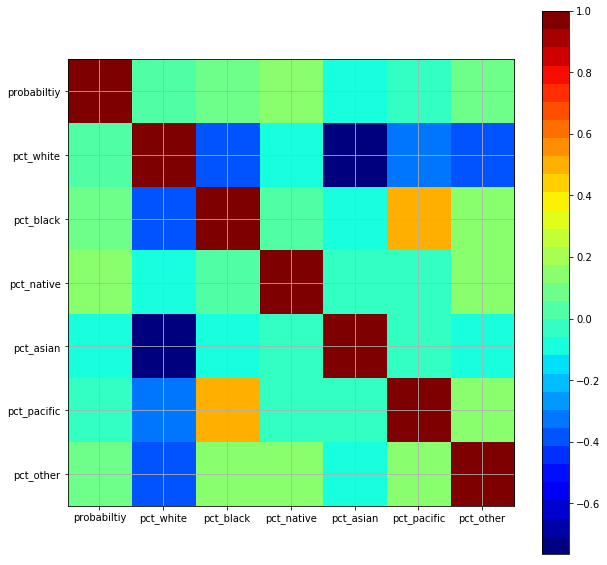

In [13]:

import matplotlib.pyplot as plt

def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    #plt.title('Abalone Feature Correlation')
    #labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
    plt.xticks(range(len(df.columns)), df.columns)
    plt.yticks(range(len(df.columns)), df.columns)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax)
    plt.show()
correlation_matrix(census_prob_corr)

In [14]:
# mean probability of each tract
agg_df = probs_geodf.groupby("geoid10").mean().reset_index()
agg_df['tract'] = agg_df.geoid10.str[5:].astype(int)
agg_df = pd.merge(agg_df, tracts_geodf, on="geoid10")
agg_geodf = gpd.GeoDataFrame(agg_df)
agg_geodf.crs = tracts_geodf.crs
agg_geodf.head()

,geoid10,probabiltiy,tract,geometry
0,06075010100,0.346643,10100,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
1,06075010200,0.202997,10200,"(POLYGON ((-122.418445 37.80458, -122.418341 3..."
2,06075010300,0.074430,10300,"(POLYGON ((-122.418445 37.80458, -122.418531 3..."
3,06075010400,0.073681,10400,"(POLYGON ((-122.402421 37.799382, -122.403253 ..."
4,06075010500,0.235344,10500,"(POLYGON ((-122.400681 37.796777, -122.400863 ..."


In [15]:
# merge agg_geodf and census
census_agg_prob = pd.merge(agg_geodf, census, on="tract")
census_agg_prob.head()

,geoid10,probabiltiy,tract,geometry,pop_all,pop_white,pop_black,pop_native,pop_asian,pop_pacific,pop_other,pct_white,pct_black,pct_native,pct_asian,pct_pacific,pct_other
0,06075010100,0.346643,10100,"(POLYGON ((-122.421076 37.812889, -122.420182 ...",3967,1955,135,0,1549,0,189,0.492816,0.034031,0.000000,0.390471,0.000000,0.047643
1,06075010200,0.202997,10200,"(POLYGON ((-122.418445 37.80458, -122.418341 3...",4363,3677,34,0,488,9,57,0.842769,0.007793,0.000000,0.111850,0.002063,0.013064
2,06075010300,0.074430,10300,"(POLYGON ((-122.418445 37.80458, -122.418531 3...",4377,2708,0,0,1445,0,120,0.618689,0.000000,0.000000,0.330135,0.000000,0.027416
3,06075010400,0.073681,10400,"(POLYGON ((-122.402421 37.799382, -122.403253 ...",4645,2772,1,4,1320,0,71,0.596771,0.000215,0.000861,0.284177,0.000000,0.015285
4,06075010500,0.235344,10500,"(POLYGON ((-122.400681 37.796777, -122.400863 ...",2691,1487,243,0,659,0,47,0.552583,0.090301,0.000000,0.244890,0.000000,0.017466


In [16]:
# base map
sf_coordinates = (37.76, -122.431297)
sf_map = folium.Map(location=sf_coordinates, zoom_start=12,
                    control_scale=True, tiles="Stamen Toner")
sf_map

In [17]:
## Additional Map
# mean predicted crime probability
folium.Choropleth(
    geo_data=census_agg_prob.to_json(),
    name='Mean predicted crime probability',
    data=census_agg_prob,
    columns=['geoid10', 'probabiltiy'],
    key_on='feature.properties.geoid10',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Mean predicted crime probability'
).add_to(sf_map)

# census
folium.Choropleth(
    geo_data=census_agg_prob.to_json(),
    name='Percentage of black',
    data=census_agg_prob,
    columns=['geoid10', 'pct_black'],
    key_on='feature.properties.geoid10',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of Black'
).add_to(sf_map)

folium.LayerControl(collapsed=False).add_to(sf_map)

sf_map.save("./figures/results_map_census.html")
sf_map